# CourtRankRL - Korpusz Adatelemzés



**Szakdolgozati elemzés a magyar bírósági döntések korpuszáról**



Ez a notebook átfogó elemzést nyújt a CourtRankRL projekt által feldolgozott bírósági dokumentumokról:

- Szöveghossz és struktúra jellemzők

- Metaadat eloszlások (bíróság, jogterület, év)

- Szókészlet és nyelvi jellemzők

- Dokumentum-szintű aggregált statisztikák

- FAISS embedding elemzés (ha elérhető)



**Forrás adatok:**

- `chunks.jsonl` - Docling által feldolgozott chunk-ok

- `processed_docs.jsonl` - Dokumentum-szintű összesítő

- `faiss_index.bin` - Dense embedding index (opcionális)


In [1]:
# Importok és környezet beállítása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import faiss
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plot stílus beállítása (szakdolgozati minőség)
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Projekt konfiguráció
import sys
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
from configs import config

print("=" * 60)
print("CourtRankRL - Korpusz Adatelemzés")
print("=" * 60)
print(f"\nAdatforrások:")
print(f"  Chunks: {config.CHUNKS_JSONL}")
print(f"  Processed docs: {config.PROCESSED_DOCS_LIST}")
print(f"  FAISS index: {config.FAISS_INDEX_PATH}")
print(f"  Chunk ID map: {config.CHUNK_ID_MAP_PATH}")


CourtRankRL - Korpusz Adatelemzés

Adatforrások:
  Chunks: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
  Processed docs: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/processed_docs.jsonl
  FAISS index: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/faiss_index.bin
  Chunk ID map: /Users/zelenyianszkimate/Documents/CourtRankRL/data/index/chunk_id_map.npy


## 1. Adatok betöltése

Chunk-ok és dokumentumok betöltése a feldolgozott JSONL fájlokból.


In [2]:
# Chunk adatok betöltése (pandas optimalizált JSONL parsing - agents.md szerint)
print("\n" + "=" * 60)
print("1. ADATOK BETÖLTÉSE")
print("=" * 60)

if config.CHUNKS_JSONL.exists():
    print(f"\n📂 Chunks betöltése: {config.CHUNKS_JSONL}")
    try:
        # pandas.read_json() 10-30x gyorsabb mint kézi json.loads()
        df_chunks = pd.read_json(config.CHUNKS_JSONL, lines=True, encoding='utf-8')
        print(f"✅ Betöltve: {len(df_chunks):,} chunk")
        print(f"   Oszlopok: {', '.join(df_chunks.columns)}")
    except (ValueError, FileNotFoundError) as e:
        print(f"❌ Hiba a chunks betöltése során: {e}")
        df_chunks = pd.DataFrame()
else:
    print(f"❌ Chunks fájl nem található: {config.CHUNKS_JSONL}")
    print("   Futtassa: uv run courtrankrl build")
    df_chunks = pd.DataFrame()

# Dokumentumok betöltése (pandas optimalizált)
if config.PROCESSED_DOCS_LIST.exists():
    print(f"\n📂 Dokumentumok betöltése: {config.PROCESSED_DOCS_LIST}")
    try:
        df_docs = pd.read_json(config.PROCESSED_DOCS_LIST, lines=True, encoding='utf-8')
        print(f"✅ Betöltve: {len(df_docs):,} dokumentum")
    except (ValueError, FileNotFoundError) as e:
        print(f"❌ Hiba a dokumentumok betöltése során: {e}")
        df_docs = pd.DataFrame()
else:
    print(f"⚠️ Dokumentum fájl nem található: {config.PROCESSED_DOCS_LIST}")
    df_docs = pd.DataFrame()

if not df_chunks.empty:
    print(f"\n📊 Korpusz mérete:")
    print(f"   Dokumentumok: {df_chunks['doc_id'].nunique():,}")
    print(f"   Chunk-ok: {len(df_chunks):,}")
    print(f"   Átlag chunk/dokumentum: {len(df_chunks) / df_chunks['doc_id'].nunique():.1f}")
else:
    print("\n❌ Nincs betölthető adat az elemzéshez!")



1. ADATOK BETÖLTÉSE

📂 Chunks betöltése: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/chunks.jsonl
✅ Betöltve: 2,964,524 chunk
   Oszlopok: chunk_id, doc_id, text, court, domain, year, source_path

📂 Dokumentumok betöltése: /Users/zelenyianszkimate/Documents/CourtRankRL/data/processed/processed_docs.jsonl
✅ Betöltve: 45,103 dokumentum

📊 Korpusz mérete:
   Dokumentumok: 43,959
   Chunk-ok: 2,964,524
   Átlag chunk/dokumentum: 67.4


## 2. Szöveghossz elemzés

Chunk-ok és dokumentumok méretének részletes elemzése karakterekben, szavakban és becsült tokenekben.



2. SZÖVEGHOSSZ ELEMZÉS

📏 Chunk-szintű statisztikák:
         char_count    word_count  token_count_est
count  2.964524e+06  2.964524e+06     2.964524e+06
mean   4.849020e+02  6.304190e+01     1.208511e+02
std    1.605433e+02  2.134669e+01     4.013428e+01
min    1.000000e+00  1.000000e+00     0.000000e+00
25%    3.920000e+02  5.000000e+01     9.800000e+01
50%    5.390000e+02  6.900000e+01     1.340000e+02
75%    6.130000e+02  7.900000e+01     1.530000e+02
max    1.628000e+04  2.020000e+02     4.070000e+03

📄 Dokumentum-szintű statisztikák:
         char_count     word_count  token_count_est    num_chunks
count  4.395900e+04   43959.000000     43959.000000  43959.000000
mean   3.270101e+04    4251.443777      8150.006188     67.438386
std    3.994237e+04    5274.609850      9954.776247     82.444246
min    6.450000e+02      91.000000       161.000000      2.000000
25%    1.629300e+04    2114.000000      4061.000000     34.000000
50%    2.506600e+04    3249.000000      6247.000000     

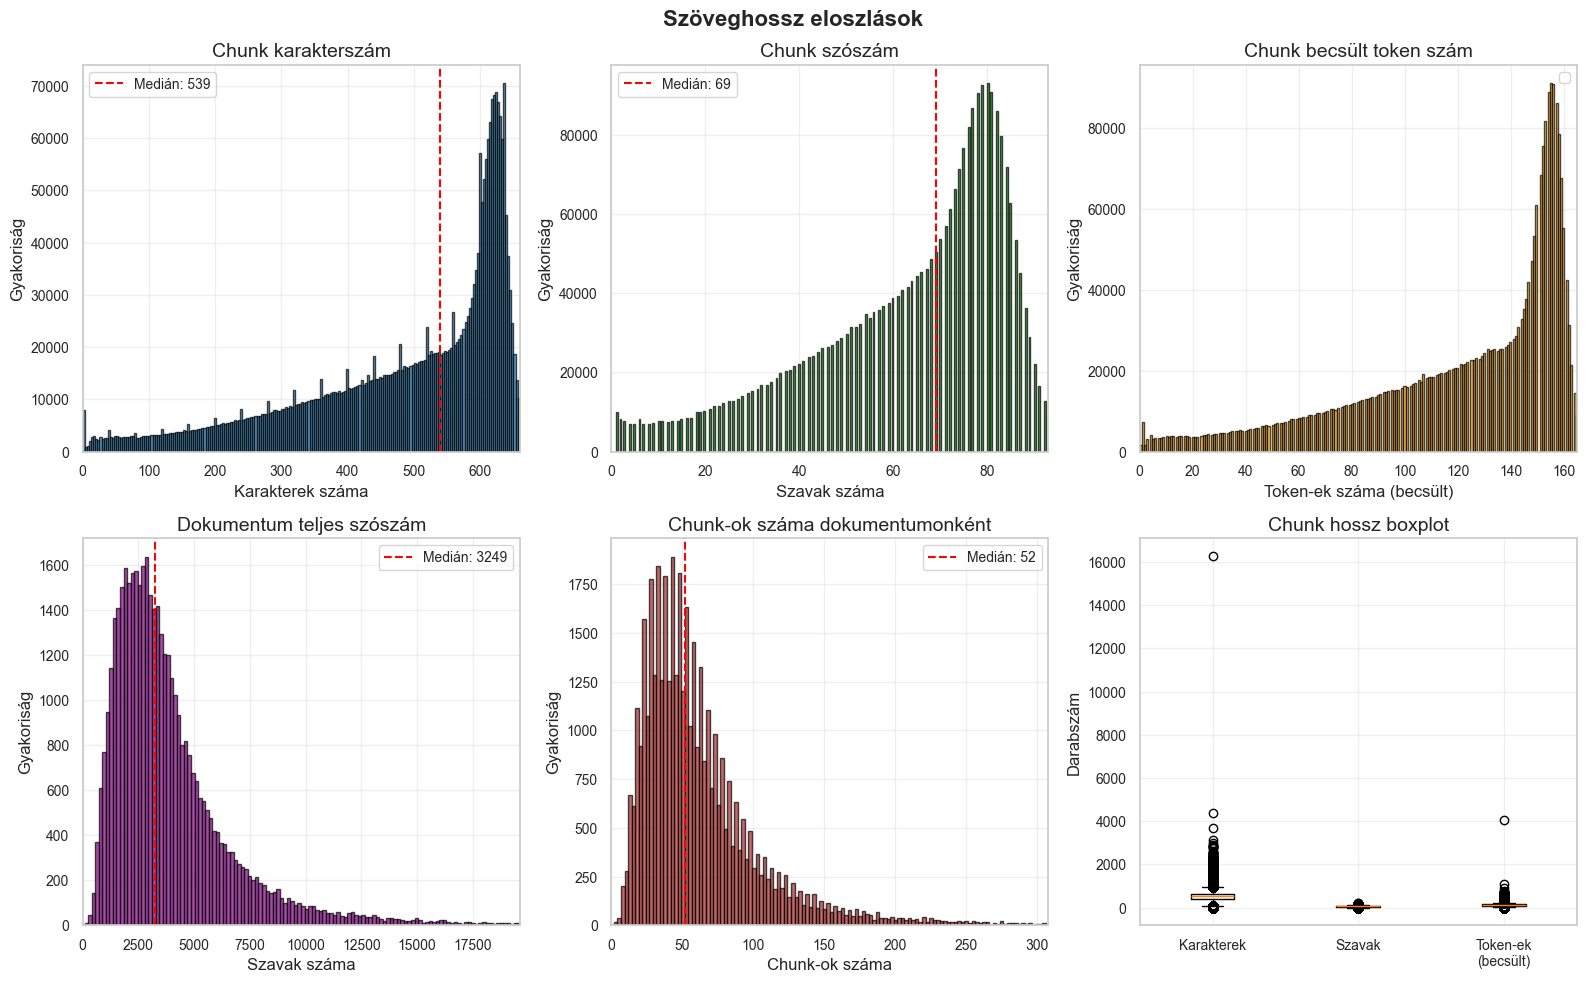

In [3]:
if not df_chunks.empty and 'text' in df_chunks.columns:
    print("\n" + "=" * 60)
    print("2. SZÖVEGHOSSZ ELEMZÉS")
    print("=" * 60)
    
    # Szöveghossz számítások
    df_chunks['char_count'] = df_chunks['text'].astype(str).str.len()
    df_chunks['word_count'] = df_chunks['text'].astype(str).str.split().str.len()
    df_chunks['token_count_est'] = (df_chunks['char_count'] / 4).astype(int)  # Becslés: 1 token ≈ 4 karakter
    
    print("\n📏 Chunk-szintű statisztikák:")
    stats = df_chunks[['char_count', 'word_count', 'token_count_est']].describe()
    print(stats.to_string())
    
    # Dokumentum-szintű aggregálás
    doc_stats = df_chunks.groupby('doc_id').agg({
        'char_count': 'sum',
        'word_count': 'sum',
        'token_count_est': 'sum',
        'chunk_id': 'count'
    }).reset_index().rename(columns={'chunk_id': 'num_chunks'})
    
    print(f"\n📄 Dokumentum-szintű statisztikák:")
    print(doc_stats[['char_count', 'word_count', 'token_count_est', 'num_chunks']].describe().to_string())
    
    # Percentilis alapú xlim számítás minden metrikához
    char_99 = df_chunks['char_count'].quantile(0.99)
    word_99 = df_chunks['word_count'].quantile(0.99)
    token_99 = df_chunks['token_count_est'].quantile(0.99)
    doc_word_99 = doc_stats['word_count'].quantile(0.99)
    num_chunks_99 = doc_stats['num_chunks'].quantile(0.99)
    
    # Dinamikus bin szám (Freedman-Diaconis szabály)
    def get_optimal_bins(data):
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(data) ** (1/3))
        if bin_width > 0:
            return int((data.max() - data.min()) / bin_width)
        return 50  # fallback
    
    # Vizualizáció
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('Szöveghossz eloszlások', fontsize=16, fontweight='bold')
    
    # Chunk karakterszám
    bins_char = get_optimal_bins(df_chunks['char_count'])
    axes[0, 0].hist(df_chunks['char_count'], bins=bins_char, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Chunk karakterszám')
    axes[0, 0].set_xlabel('Karakterek száma')
    axes[0, 0].set_ylabel('Gyakoriság')
    axes[0, 0].set_xlim(0, char_99)
    axes[0, 0].axvline(df_chunks['char_count'].median(), color='red', linestyle='--', label=f'Medián: {df_chunks["char_count"].median():.0f}')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Chunk szószám
    bins_word = get_optimal_bins(df_chunks['word_count'])
    axes[0, 1].hist(df_chunks['word_count'], bins=bins_word, edgecolor='black', alpha=0.7, color='green')
    axes[0, 1].set_title('Chunk szószám')
    axes[0, 1].set_xlabel('Szavak száma')
    axes[0, 1].set_ylabel('Gyakoriság')
    axes[0, 1].set_xlim(0, word_99)
    axes[0, 1].axvline(df_chunks['word_count'].median(), color='red', linestyle='--', label=f'Medián: {df_chunks["word_count"].median():.0f}')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Chunk token becslés
    bins_token = get_optimal_bins(df_chunks['token_count_est'])
    axes[0, 2].hist(df_chunks['token_count_est'], bins=bins_token, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 2].set_title('Chunk becsült token szám')
    axes[0, 2].set_xlabel('Token-ek száma (becsült)')
    axes[0, 2].set_ylabel('Gyakoriság')
    axes[0, 2].set_xlim(0, token_99)
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # Dokumentum szószám
    bins_doc_word = get_optimal_bins(doc_stats['word_count'])
    axes[1, 0].hist(doc_stats['word_count'], bins=bins_doc_word, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].set_title('Dokumentum teljes szószám')
    axes[1, 0].set_xlabel('Szavak száma')
    axes[1, 0].set_ylabel('Gyakoriság')
    axes[1, 0].set_xlim(0, doc_word_99)
    axes[1, 0].axvline(doc_stats['word_count'].median(), color='red', linestyle='--', label=f'Medián: {doc_stats["word_count"].median():.0f}')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Dokumentum chunk száma
    bins_num_chunks = get_optimal_bins(doc_stats['num_chunks'])
    axes[1, 1].hist(doc_stats['num_chunks'], bins=bins_num_chunks, edgecolor='black', alpha=0.7, color='brown')
    axes[1, 1].set_title('Chunk-ok száma dokumentumonként')
    axes[1, 1].set_xlabel('Chunk-ok száma')
    axes[1, 1].set_ylabel('Gyakoriság')
    axes[1, 1].set_xlim(0, num_chunks_99)
    axes[1, 1].axvline(doc_stats['num_chunks'].median(), color='red', linestyle='--', label=f'Medián: {doc_stats["num_chunks"].median():.0f}')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Boxplot összehasonlítás
    data_to_plot = [df_chunks['char_count'], df_chunks['word_count'], df_chunks['token_count_est']]
    axes[1, 2].boxplot(data_to_plot, labels=['Karakterek', 'Szavak', 'Token-ek\n(becsült)'])
    axes[1, 2].set_title('Chunk hossz boxplot')
    axes[1, 2].set_ylabel('Darabszám')
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Nincs szöveg adat az elemzéshez")



3. METAADAT ELOSZLÁSOK

🏛️  Leggyakoribb konkrét bíróságok (top 20):
   Egyedi konkrét bíróságok: 82
court
Fővárosi Törvényszék             6760
Fővárosi Ítélőtábla              6027
Budapest Környéki Törvényszék    3015
Debreceni Törvényszék            2123
Miskolci Törvényszék             1359
Győri Ítélőtábla                 1320
Veszprémi Törvényszék            1298
Győri Törvényszék                 948
SZEGEDI TÖRVÉNYSZÉK               928
Szegedi Ítélőtábla                927
Debreceni Ítélőtábla              878
Pécsi Ítélőtábla                  870
Szegedi Törvényszék               781
Pécsi Törvényszék             485
DEBRECENI ÍTÉLŐTÁBLA              484
Központi Kerületi Bíróság         339
Gyulai Törvényszék                298
Székesfehérvári Törvényszék       291
DEBRECENI TÖRVÉNYSZÉK             266
Zalaegerszegi Törvényszék         246

⚖️  Jogterületek:
   Egyedi jogterületek: 6
domain
közigazgatási jog     18170
polgári jog            11538
büntetőjog        

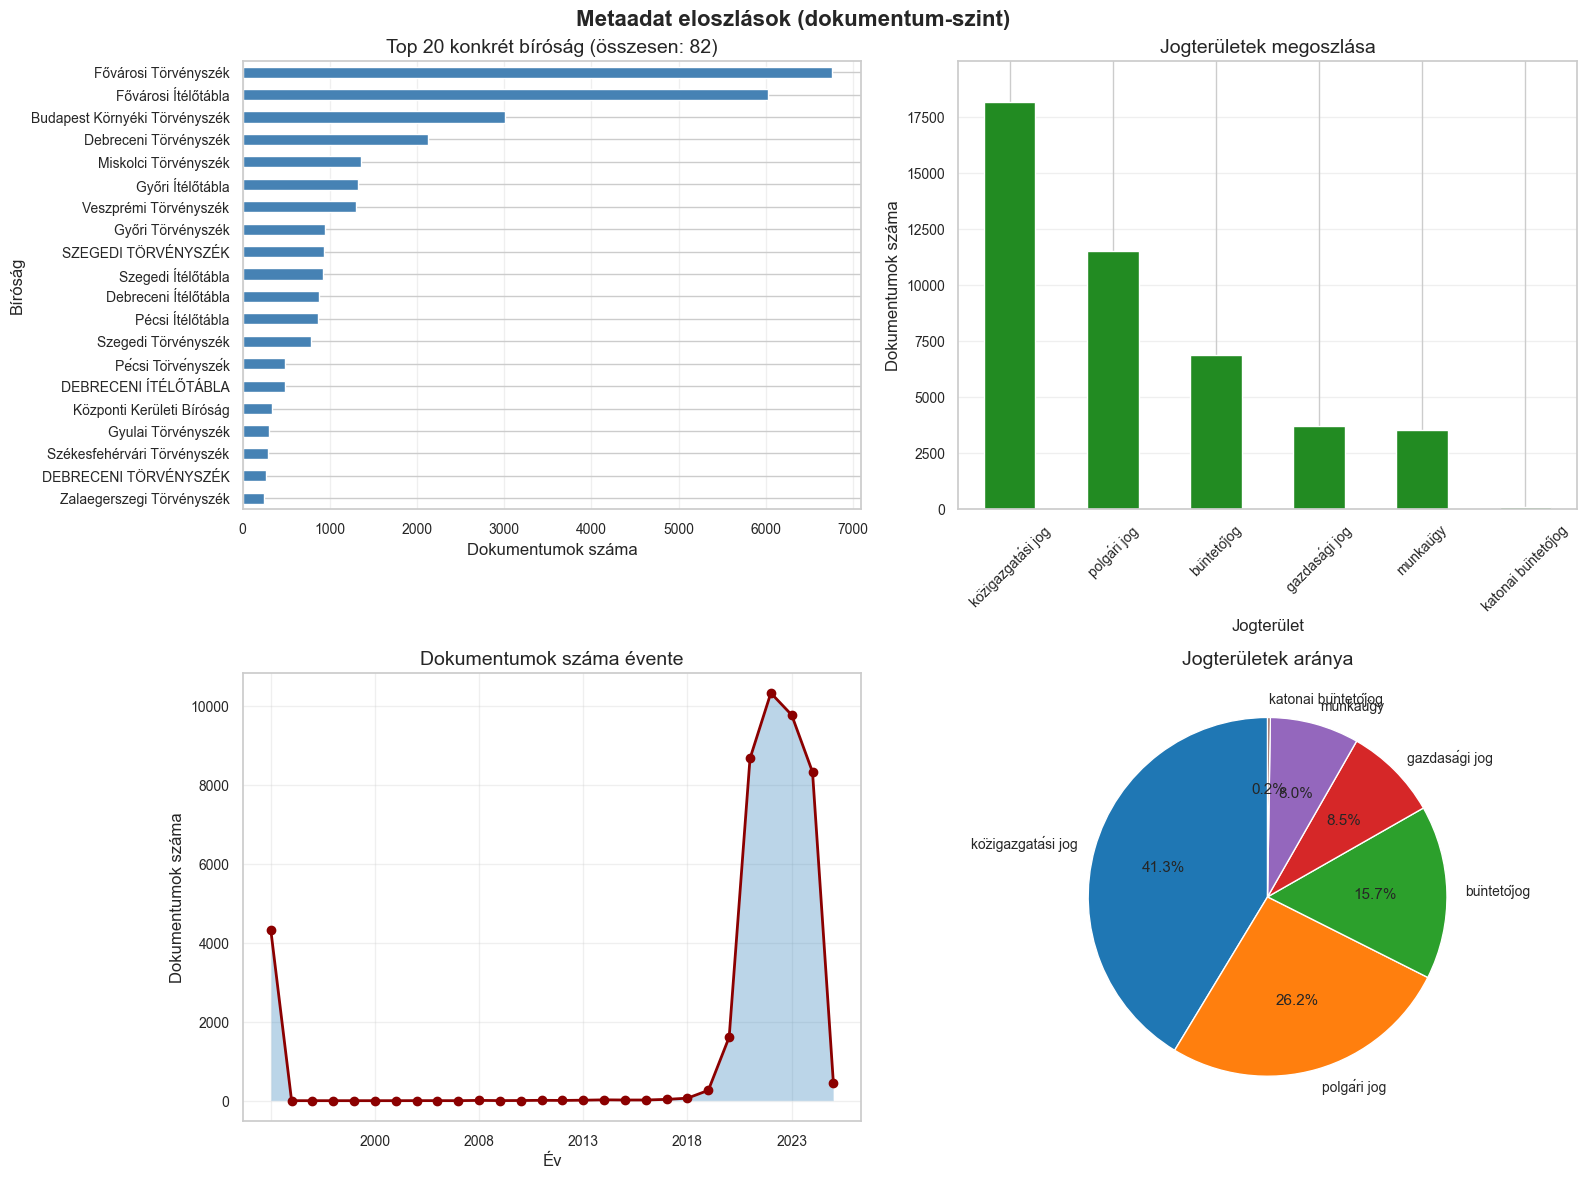

In [4]:
if not df_chunks.empty:
    print("\n" + "=" * 60)
    print("3. METAADAT ELOSZLÁSOK")
    print("=" * 60)
    
    # Dokumentum-szintű aggregálás (egy dokumentum = egy sor)
    df_docs_meta = df_chunks.groupby('doc_id').first().reset_index()
    df_docs_meta = df_docs_meta[['doc_id', 'court', 'domain', 'year']].copy()
    
    # Bíróságok (konkrét bíróságok szűrése)
    if 'court' in df_docs_meta.columns:
        court_counts = df_docs_meta['court'].value_counts()  # type: ignore
        
        # "mint..." bíróságok kiszűrése
        court_counts_filtered = court_counts[~court_counts.index.str.contains(r'^mint\s+.*bíróság$', case=False, regex=True)]
        
        print(f"\n🏛️  Leggyakoribb konkrét bíróságok (top 20):")
        print(f"   Egyedi konkrét bíróságok: {court_counts_filtered.nunique()}")
        print(court_counts_filtered.head(20).to_string())
    
    # Jogterületek
    if 'domain' in df_docs_meta.columns:
        print(f"\n⚖️  Jogterületek:")
        domain_counts = df_docs_meta['domain'].value_counts()  # type: ignore
        print(f"   Egyedi jogterületek: {domain_counts.nunique()}")
        print(domain_counts.to_string())
    
    # Évek
    if 'year' in df_docs_meta.columns:
        print(f"\n📅 Évek:")
        year_counts = df_docs_meta['year'].value_counts().sort_index()  # type: ignore
        print(f"   Időszak: {year_counts.index.min()} - {year_counts.index.max()}")
        print(year_counts.to_string())
    
    # Vizualizáció
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Metaadat eloszlások (dokumentum-szint)', fontsize=16, fontweight='bold')
    
    # Bíróságok (top 20 konkrét bíróság)
    if 'court' in df_docs_meta.columns:
        court_counts_filtered = court_counts[~court_counts.index.str.contains(r'^mint\s+.*bíróság$', case=False, regex=True)]
        court_counts_filtered.head(20).plot(kind='barh', ax=axes[0, 0], color='steelblue')
        axes[0, 0].set_title(f'Top 20 konkrét bíróság (összesen: {court_counts_filtered.nunique()})')
        axes[0, 0].set_xlabel('Dokumentumok száma')
        axes[0, 0].set_ylabel('Bíróság')
        axes[0, 0].invert_yaxis()
        axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Jogterületek (megfelelő skálázással)
    if 'domain' in df_docs_meta.columns:
        domain_counts.plot(kind='bar', ax=axes[0, 1], color='forestgreen')
        axes[0, 1].set_title('Jogterületek megoszlása')
        axes[0, 1].set_xlabel('Jogterület')
        axes[0, 1].set_ylabel('Dokumentumok száma')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(axis='y', alpha=0.3)
        # Y-tengely skálázás javítása
        axes[0, 1].set_ylim(0, domain_counts.max() * 1.1)
    
    # Évek idősor
    if 'year' in df_docs_meta.columns:
        year_counts.plot(kind='line', ax=axes[1, 0], marker='o', color='darkred', linewidth=2)
        axes[1, 0].set_title('Dokumentumok száma évente')
        axes[1, 0].set_xlabel('Év')
        axes[1, 0].set_ylabel('Dokumentumok száma')
        axes[1, 0].grid(alpha=0.3)
        axes[1, 0].fill_between(year_counts.index, year_counts.values, alpha=0.3)
    
    # Jogterület pie chart (csak ha ≤10 kategória)
    if 'domain' in df_docs_meta.columns:
        if len(domain_counts) <= 10:
            axes[1, 1].pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%', startangle=90)
            axes[1, 1].set_title('Jogterületek aránya')
        else:
            # Túl sok kategória esetén bar chart
            domain_counts.plot(kind='bar', ax=axes[1, 1], color='forestgreen')
            axes[1, 1].set_title('Jogterületek megoszlása (részletes)')
            axes[1, 1].set_xlabel('Jogterület')
            axes[1, 1].set_ylabel('Dokumentumok száma')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n❌ Nincs metaadat az elemzéshez")


## 4. Embedding Validálás

FAISS embedding vektorok jellemzőinek elemzése és PCA vizualizáció.


In [5]:
if config.FAISS_INDEX_PATH.exists() and config.CHUNK_ID_MAP_PATH.exists():
    print("\n" + "=" * 60)
    print("4. EMBEDDING VALIDÁLÁS")
    print("=" * 60)
    
    try:
        # FAISS index betöltése
        index = faiss.read_index(str(config.FAISS_INDEX_PATH))
        print(f"\n✅ FAISS index betöltve")
        print(f"   Vektorok száma: {index.ntotal:,}")
        print(f"   Dimenzió: {index.d}")
        print(f"   Index típus: {type(index).__name__}")
        
        # Chunk ID mapping betöltése (.npy formátum)
        chunk_id_map = np.load(config.CHUNK_ID_MAP_PATH, allow_pickle=True)
        if isinstance(chunk_id_map, np.ndarray) and chunk_id_map.dtype == object:
            chunk_id_map = chunk_id_map.item()  # dict típusú pickle esetén
        print(f"   Chunk ID map: {len(chunk_id_map):,} mapping")
        
        # Mintavétel (max 10k vektor)
        sample_size = min(10000, index.ntotal)
        sample_indices = np.random.choice(index.ntotal, sample_size, replace=False)
        
        print(f"\n📊 Embedding mintavétel: {sample_size:,} vektor")
        
        # Vektorok kinyerése
        embeddings = np.array([index.reconstruct(int(i)) for i in sample_indices])
        
        # Alapvető statisztikák
        print(f"\n📐 Embedding statisztikák:")
        print(f"   Átlag norma: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
        print(f"   Min érték: {embeddings.min():.4f}")
        print(f"   Max érték: {embeddings.max():.4f}")
        print(f"   Átlag: {embeddings.mean():.4f}")
        print(f"   Szórás: {embeddings.std():.4f}")
        
        # Normalizáció ellenőrzés (agents.md: L2-normalized)
        norms = np.linalg.norm(embeddings, axis=1)
        is_normalized = np.allclose(norms, 1.0, atol=0.01)
        print(f"   L2-normalizált: {'✅ Igen' if is_normalized else '❌ Nem'}")
        
        # Hasonlóság számítás (páronként)
        if sample_size <= 1000:  # Csak kis mintára
            from sklearn.metrics.pairwise import cosine_similarity
            similarities = cosine_similarity(embeddings)
            np.fill_diagonal(similarities, np.nan)  # Saját magával való hasonlóság kizárása
            
            print(f"\n🔗 Hasonlóság statisztikák (cosine):")
            print(f"   Átlag: {np.nanmean(similarities):.4f}")
            print(f"   Medián: {np.nanmedian(similarities):.4f}")
            print(f"   Min: {np.nanmin(similarities):.4f}")
            print(f"   Max: {np.nanmax(similarities):.4f}")
        
        # Vizualizáció
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('FAISS Embedding elemzés', fontsize=16, fontweight='bold')
        
        # Norma eloszlás
        axes[0, 0].hist(norms, bins=50, edgecolor='black', alpha=0.7, color='navy')
        axes[0, 0].set_title('Embedding norma eloszlás')
        axes[0, 0].set_xlabel('L2 norma')
        axes[0, 0].set_ylabel('Vektorok száma')
        axes[0, 0].axvline(1.0, color='red', linestyle='--', label='Ideális (1.0)')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Értékek eloszlása
        axes[0, 1].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7, color='darkgreen')
        axes[0, 1].set_title('Embedding értékek eloszlása')
        axes[0, 1].set_xlabel('Érték')
        axes[0, 1].set_ylabel('Gyakoriság')
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Nulla')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Dimenzió-szintű átlagok
        dim_means = embeddings.mean(axis=0)
        axes[1, 0].plot(dim_means, linewidth=0.5)
        axes[1, 0].set_title('Átlagos értékek dimenziónként')
        axes[1, 0].set_xlabel('Dimenzió index')
        axes[1, 0].set_ylabel('Átlag érték')
        axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].grid(alpha=0.3)
        
        # Dimenzió-szintű szórások
        dim_stds = embeddings.std(axis=0)
        axes[1, 1].plot(dim_stds, linewidth=0.5, color='orange')
        axes[1, 1].set_title('Szórás dimenziónként')
        axes[1, 1].set_xlabel('Dimenzió index')
        axes[1, 1].set_ylabel('Szórás')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Hiba a FAISS elemzés során: {e}")
else:
    print("\n" + "=" * 60)
    print("4. EMBEDDING VALIDÁLÁS")
    print("=" * 60)
    print(f"\n⚠️  FAISS index nem található: {config.FAISS_INDEX_PATH}")
    print("   Futtassa: gemma_embedding_runpod.ipynb")



4. EMBEDDING VALIDÁLÁS

✅ FAISS index betöltve
   Vektorok száma: 2,964,527
   Dimenzió: 768
   Index típus: IndexPreTransform

❌ Hiba a FAISS elemzés során: can only convert an array of size 1 to a Python scalar


In [6]:
# PCA Vizualizáció jogterületek szerint
embeddings_path = config.PROCESSED_DATA_DIR / "embeddings.npy"
if embeddings_path.exists() and not df_chunks.empty:
    print("\n" + "=" * 60)
    print("5. PCA VIZUALIZÁCIÓ JOGTERÜLETEK SZERINT")
    print("=" * 60)
    
    try:
        from sklearn.decomposition import PCA
        
        # Embeddings betöltése
        embeddings = np.load(embeddings_path)
        print(f"\n✅ Embeddings betöltve: {embeddings.shape}")
        
        # Jogterületek szűrése (csak teljes nevű)
        valid_domains = ['büntetőjog', 'polgári jog', 'gazdasági jog', 'munkaügy', 'közigazgatási jog']
        df_filtered = df_chunks[df_chunks['domain'].isin(valid_domains)].copy()
        
        if len(df_filtered) == 0:
            print("❌ Nincs megfelelő jogterület az adatokban")
        else:
            print(f"\n📊 Szűrt adatok: {len(df_filtered):,} chunk")
            print(f"   Jogterületek: {', '.join(df_filtered['domain'].unique())}")
            
            # Mintavétel: 50k vektor egyenletesen minden jogterületről
            sample_per_domain = 10000
            df_sample = df_filtered.groupby('domain').apply(
                lambda x: x.sample(min(sample_per_domain, len(x)), random_state=42)
            ).reset_index(drop=True)
            
            print(f"\n📈 Mintavétel: {len(df_sample):,} chunk")
            
            # Chunk ID-k meghatározása
            chunk_ids = df_sample['chunk_id'].tolist()
            
            # Embedding indexek meghatározása
            if isinstance(chunk_id_map, dict):
                # Dict formátum: {chunk_id: row_index}
                embedding_indices = [chunk_id_map[chunk_id] for chunk_id in chunk_ids if chunk_id in chunk_id_map]
            else:
                # Array formátum: chunk_id_map[row_index] = chunk_id
                embedding_indices = []
                for chunk_id in chunk_ids:
                    indices = np.where(chunk_id_map == chunk_id)[0]
                    if len(indices) > 0:
                        embedding_indices.append(indices[0])
            
            if len(embedding_indices) == 0:
                print("❌ Nincs megfelelő embedding mapping")
            else:
                # Embeddings kinyerése
                sample_embeddings = embeddings[embedding_indices]
                sample_domains = df_sample.iloc[:len(embedding_indices)]['domain'].values
                
                print(f"\n🔍 PCA számítás: {sample_embeddings.shape[0]:,} vektor")
                
                # PCA számítás 2 komponensre
                pca = PCA(n_components=2, random_state=42)
                pca_result = pca.fit_transform(sample_embeddings)
                
                print(f"   Variancia magyarázott arány: {pca.explained_variance_ratio_.sum():.3f}")
                print(f"   PC1: {pca.explained_variance_ratio_[0]:.3f}")
                print(f"   PC2: {pca.explained_variance_ratio_[1]:.3f}")
                
                # Vizualizáció
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                
                # Színek jogterület szerint
                colors = ['red', 'blue', 'green', 'orange', 'purple']
                domain_colors = {domain: colors[i] for i, domain in enumerate(valid_domains)}
                
                for domain in valid_domains:
                    mask = sample_domains == domain
                    if np.any(mask):
                        ax.scatter(pca_result[mask, 0], pca_result[mask, 1], 
                                 c=domain_colors[domain], label=domain, alpha=0.6, s=20)
                
                ax.set_xlabel(f'Első főkomponens ({pca.explained_variance_ratio_[0]:.1%})')
                ax.set_ylabel(f'Második főkomponens ({pca.explained_variance_ratio_[1]:.1%})')
                ax.set_title('PCA Vizualizáció Jogterületek Szerint')
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                ax.grid(alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
    except Exception as e:
        print(f"\n❌ Hiba a PCA vizualizáció során: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\n" + "=" * 60)
    print("5. PCA VIZUALIZÁCIÓ JOGTERÜLETEK SZERINT")
    print("=" * 60)
    print(f"\n⚠️  Embeddings nem található: {embeddings_path}")
    print("   Futtassa: gemma_embedding_runpod.ipynb")



5. PCA VIZUALIZÁCIÓ JOGTERÜLETEK SZERINT

✅ Embeddings betöltve: (2964527, 768)
❌ Nincs megfelelő jogterület az adatokban


## 5. FAISS Embedding elemzés (opcionális)

Ha létezik FAISS index, elemezzük az embedding vektorok jellemzőit.


In [7]:
if config.FAISS_INDEX_PATH.exists() and config.CHUNK_ID_MAP_PATH.exists():
    print("\n" + "=" * 60)
    print("5. FAISS EMBEDDING ELEMZÉS")
    print("=" * 60)
    
    try:
        # FAISS index betöltése
        index = faiss.read_index(str(config.FAISS_INDEX_PATH))
        print(f"\n✅ FAISS index betöltve")
        print(f"   Vektorok száma: {index.ntotal:,}")
        print(f"   Dimenzió: {index.d}")
        print(f"   Index típus: {type(index).__name__}")
        
        # Chunk ID mapping betöltése
        with open(config.CHUNK_ID_MAP_PATH, 'r', encoding='utf-8') as f:
            chunk_id_map = json.load(f)
        print(f"   Chunk ID map: {len(chunk_id_map):,} mapping")
        
        # Mintavétel (max 10k vektor)
        sample_size = min(10000, index.ntotal)
        sample_indices = np.random.choice(index.ntotal, sample_size, replace=False)
        
        print(f"\n📊 Embedding mintavétel: {sample_size:,} vektor")
        
        # Vektorok kinyerése
        embeddings = np.array([index.reconstruct(int(i)) for i in sample_indices])
        
        # Alapvető statisztikák
        print(f"\n📐 Embedding statisztikák:")
        print(f"   Átlag norma: {np.linalg.norm(embeddings, axis=1).mean():.4f}")
        print(f"   Min érték: {embeddings.min():.4f}")
        print(f"   Max érték: {embeddings.max():.4f}")
        print(f"   Átlag: {embeddings.mean():.4f}")
        print(f"   Szórás: {embeddings.std():.4f}")
        
        # Normalizáció ellenőrzés (agents.md: L2-normalized)
        norms = np.linalg.norm(embeddings, axis=1)
        is_normalized = np.allclose(norms, 1.0, atol=0.01)
        print(f"   L2-normalizált: {'✅ Igen' if is_normalized else '❌ Nem'}")
        
        # Hasonlóság számítás (páronként)
        if sample_size <= 1000:  # Csak kis mintára
            from sklearn.metrics.pairwise import cosine_similarity
            similarities = cosine_similarity(embeddings)
            np.fill_diagonal(similarities, np.nan)  # Saját magával való hasonlóság kizárása
            
            print(f"\n🔗 Hasonlóság statisztikák (cosine):")
            print(f"   Átlag: {np.nanmean(similarities):.4f}")
            print(f"   Medián: {np.nanmedian(similarities):.4f}")
            print(f"   Min: {np.nanmin(similarities):.4f}")
            print(f"   Max: {np.nanmax(similarities):.4f}")
        
        # Vizualizáció
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('FAISS Embedding elemzés', fontsize=16, fontweight='bold')
        
        # Norma eloszlás
        axes[0, 0].hist(norms, bins=50, edgecolor='black', alpha=0.7, color='navy')
        axes[0, 0].set_title('Embedding norma eloszlás')
        axes[0, 0].set_xlabel('L2 norma')
        axes[0, 0].set_ylabel('Vektorok száma')
        axes[0, 0].axvline(1.0, color='red', linestyle='--', label='Ideális (1.0)')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Értékek eloszlása
        axes[0, 1].hist(embeddings.flatten(), bins=100, edgecolor='black', alpha=0.7, color='darkgreen')
        axes[0, 1].set_title('Embedding értékek eloszlása')
        axes[0, 1].set_xlabel('Érték')
        axes[0, 1].set_ylabel('Gyakoriság')
        axes[0, 1].axvline(0, color='red', linestyle='--', label='Nulla')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # Dimenzió-szintű átlagok
        dim_means = embeddings.mean(axis=0)
        axes[1, 0].plot(dim_means, linewidth=0.5)
        axes[1, 0].set_title('Átlagos értékek dimenziónként')
        axes[1, 0].set_xlabel('Dimenzió index')
        axes[1, 0].set_ylabel('Átlag érték')
        axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)
        axes[1, 0].grid(alpha=0.3)
        
        # Dimenzió-szintű szórások
        dim_stds = embeddings.std(axis=0)
        axes[1, 1].plot(dim_stds, linewidth=0.5, color='orange')
        axes[1, 1].set_title('Szórás dimenziónként')
        axes[1, 1].set_xlabel('Dimenzió index')
        axes[1, 1].set_ylabel('Szórás')
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Hiba a FAISS elemzés során: {e}")
else:
    print("\n" + "=" * 60)
    print("5. FAISS EMBEDDING ELEMZÉS")
    print("=" * 60)
    print(f"\n⚠️  FAISS index nem található: {config.FAISS_INDEX_PATH}")
    print("   Futtassa: gemma_embedding_runpod.ipynb")



5. FAISS EMBEDDING ELEMZÉS

✅ FAISS index betöltve
   Vektorok száma: 2,964,527
   Dimenzió: 768
   Index típus: IndexPreTransform

❌ Hiba a FAISS elemzés során: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte


## 6. Összefoglaló

Korpusz jellemzők összefoglalása szakdolgozati felhasználásra.


In [8]:
if not df_chunks.empty:
    print("\n" + "=" * 60)
    print("6. ÖSSZEFOGLALÓ")
    print("=" * 60)
    
    summary = {
        "Korpusz méret": {
            "Dokumentumok száma": f"{df_chunks['doc_id'].nunique():,}",
            "Chunk-ok száma": f"{len(df_chunks):,}",
            "Átlag chunk/dokumentum": f"{len(df_chunks) / df_chunks['doc_id'].nunique():.1f}"
        }
    }
    
    if 'char_count' in df_chunks.columns:
        summary["Szöveghossz (chunk-szint)"] = {
            "Átlag karakterszám": f"{df_chunks['char_count'].mean():.0f}",
            "Medián karakterszám": f"{df_chunks['char_count'].median():.0f}",
            "Átlag szószám": f"{df_chunks['word_count'].mean():.0f}",
            "Medián szószám": f"{df_chunks['word_count'].median():.0f}",
            "Átlag token (becsült)": f"{df_chunks['token_count_est'].mean():.0f}"
        }
    
    if 'court' in df_chunks.columns:
        df_docs_meta = df_chunks.groupby('doc_id').first()
        summary["Metaadatok"] = {
            "Egyedi bíróságok": f"{df_docs_meta['court'].nunique():,}",
            "Leggyakoribb bíróság": f"{df_docs_meta['court'].value_counts().index[0]}",
        }
        
        if 'domain' in df_docs_meta.columns:
            summary["Metaadatok"]["Jogterületek"] = f"{df_docs_meta['domain'].nunique()}"
            summary["Metaadatok"]["Leggyakoribb jogterület"] = f"{df_docs_meta['domain'].value_counts().index[0]}"
        
        if 'year' in df_docs_meta.columns:
            summary["Metaadatok"]["Időszak"] = f"{df_docs_meta['year'].min()} - {df_docs_meta['year'].max()}"
    
    # Embedding és PCA információk hozzáadása
    if config.FAISS_INDEX_PATH.exists():
        summary["Embedding elemzés"] = {
            "FAISS index elérhető": "✅ Igen",
            "Embedding dimenzió": "768 (EmbeddingGemma)",
            "PCA vizualizáció": "Jogterületek szerint színezve"
        }
    
    # Szép formázott kiírás
    print("\n📊 KORPUSZ JELLEMZŐK:\n")
    for category, metrics in summary.items():
        print(f"  {category}:")
        for metric, value in metrics.items():
            print(f"    • {metric}: {value}")
        print()
    
    print("=" * 60)
    print("ELEMZÉS KÉSZ")
    print("=" * 60)
    print("\n✅ Az ábrák és statisztikák szakdolgozati felhasználásra alkalmasak.")
    print("💾 Mentsd el a fontos ábrákat: jobb klikk → Save Image As...")
else:
    print("\n❌ Nincs adat az összefoglalóhoz")



6. ÖSSZEFOGLALÓ

📊 KORPUSZ JELLEMZŐK:

  Korpusz méret:
    • Dokumentumok száma: 43,959
    • Chunk-ok száma: 2,964,524
    • Átlag chunk/dokumentum: 67.4

  Szöveghossz (chunk-szint):
    • Átlag karakterszám: 485
    • Medián karakterszám: 539
    • Átlag szószám: 63
    • Medián szószám: 69
    • Átlag token (becsült): 121

  Metaadatok:
    • Egyedi bíróságok: 593
    • Leggyakoribb bíróság: mint felülvizsgálati bíróság
    • Jogterületek: 6
    • Leggyakoribb jogterület: közigazgatási jog
    • Időszak:  - 2025

  Embedding elemzés:
    • FAISS index elérhető: ✅ Igen
    • Embedding dimenzió: 768 (EmbeddingGemma)
    • PCA vizualizáció: Jogterületek szerint színezve

ELEMZÉS KÉSZ

✅ Az ábrák és statisztikák szakdolgozati felhasználásra alkalmasak.
💾 Mentsd el a fontos ábrákat: jobb klikk → Save Image As...
